# 📚 Book Data Scraping and Analysis

**Objective:**

This project demonstrates:
- Web scraping of product data from [BooksToScrape.com](http://books.toscrape.com)
- Data cleaning and transformation
- Exploratory Data Analysis (EDA)
- Creation of a Power BI dashboard to summarize insights


In [1]:
!pip install requests beautifulsoup4 pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## 🔍 Data Scraping

We scraped the first page of books including:
- Title
- Price
- Rating
- Availability


In [3]:
base_url = "http://books.toscrape.com/catalogue/page-{}.html"

titles = []
prices = []
availability = []
ratings = []

# There are 50 pages
for page in range(1, 51):
    url = base_url.format(page)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    books = soup.find_all("article", class_="product_pod")
    for book in books:
        # Title
        title = book.h3.a["title"]

        # Price
        price = book.find("p", class_="price_color").text.strip()

        # Availability
        avail = book.find("p", class_="instock availability").text.strip()

        # Rating
        rating_class = book.find("p", class_="star-rating")["class"]
        rating = rating_class[1]  # e.g., "Three", "Five"

        titles.append(title)
        prices.append(price)
        availability.append(avail)
        ratings.append(rating)

print("Scraping completed!")

Scraping completed!


## 🧹 Data Cleaning


**Convert prices to float:**

In [4]:
import re

clean_prices = [
    float(re.search(r"\d+\.\d+", p).group())
    for p in prices
]

**Convert ratings to numeric:**

In [5]:
rating_map = {
    "One": 1,
    "Two": 2,
    "Three": 3,
    "Four": 4,
    "Five": 5
}
numeric_ratings = [rating_map[r] for r in ratings]

**Create DataFrame**
---

In [6]:
df = pd.DataFrame({
    "Title": titles,
    "Price": clean_prices,
    "Availability": availability,
    "Rating": numeric_ratings
})

In [7]:
df.head()

,Title,Price,Availability,Rating
0,A Light in the Attic,51.77,In stock,3
1,Tipping the Velvet,53.74,In stock,1
2,Soumission,50.10,In stock,1
3,Sharp Objects,47.82,In stock,4
4,Sapiens: A Brief History of Humankind,54.23,In stock,5


In [9]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1000 non-null   object 
 1   Price         1000 non-null   float64
 2   Availability  1000 non-null   object 
 3   Rating        1000 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ KB


,Price,Rating
count,1000.00000,1000.000000
mean,35.07035,2.923000
std,14.44669,1.434967
min,10.00000,1.000000
25%,22.10750,2.000000
50%,35.98000,3.000000
75%,47.45750,4.000000
max,59.99000,5.000000


**Check for Missing Values**

In [10]:
df.isnull().sum()

,0
Title,0
Price,0
Availability,0
Rating,0


**Check Duplicates**

In [11]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

## 📊 Exploratory Data Analysis

**Value Counts for Categorical Columns:**

In [12]:
df["Rating"].value_counts()
df["Availability"].value_counts()

,count
Availability,
In stock,1000


**Price Distribution Plot:**

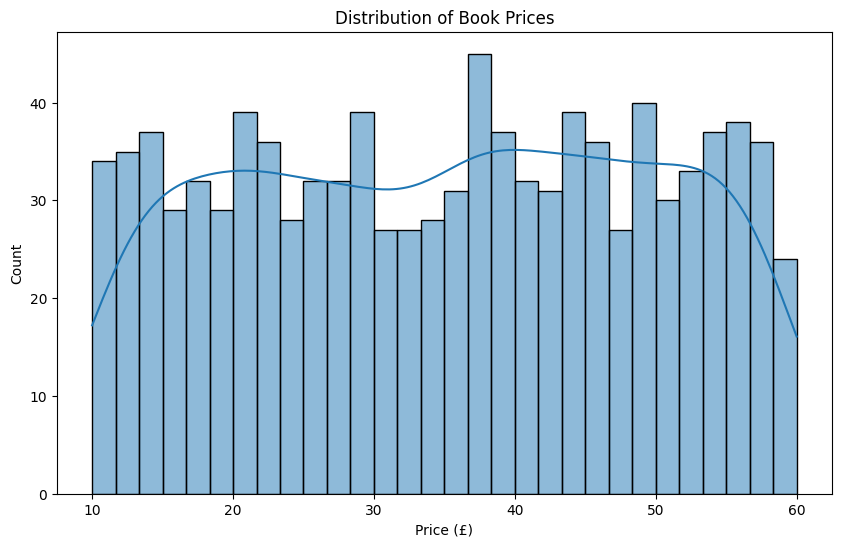

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df["Price"], bins=30, kde=True)
plt.title("Distribution of Book Prices")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

**Ratings Distribution**

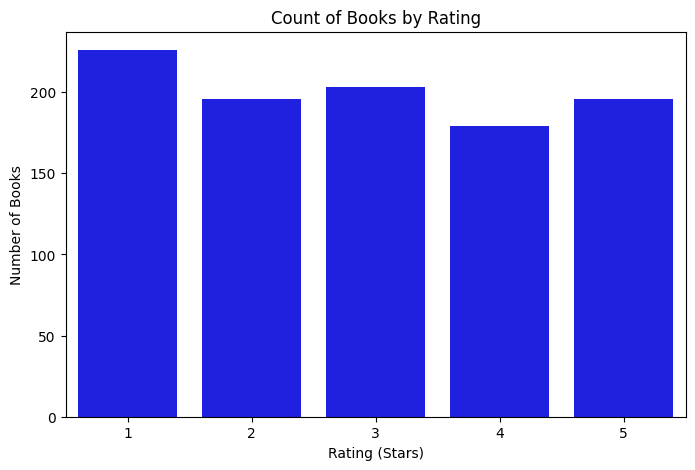

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x="Rating", data=df, color="b")
plt.title("Count of Books by Rating")
plt.xlabel("Rating (Stars)")
plt.ylabel("Number of Books")
plt.show()

**Price vs. Rating**

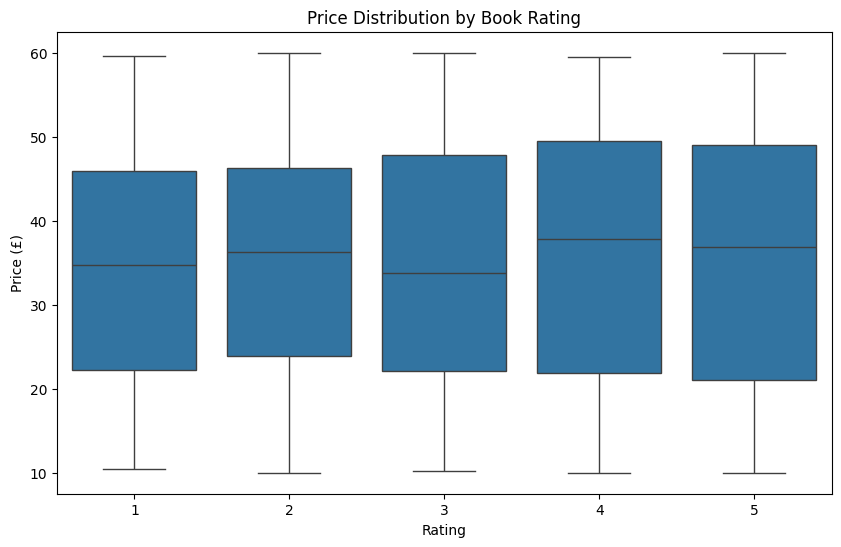

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Rating", y="Price", data=df)
plt.title("Price Distribution by Book Rating")
plt.xlabel("Rating")
plt.ylabel("Price (£)")
plt.show()

**Availability Analysis**

In [16]:
df["Availability"].unique()

array(['In stock'], dtype=object)

In [25]:
# Convert to "In Stock" / "Out of Stock" text
df["In_Stock"] = df["Availability"].apply(
    lambda x: "In Stock" if "In stock" in x else "Out of Stock"
)

# Make categorical (optional)
df["In_Stock"] = pd.Categorical(
    df["In_Stock"],
    categories=["Out of Stock", "In Stock"]
)


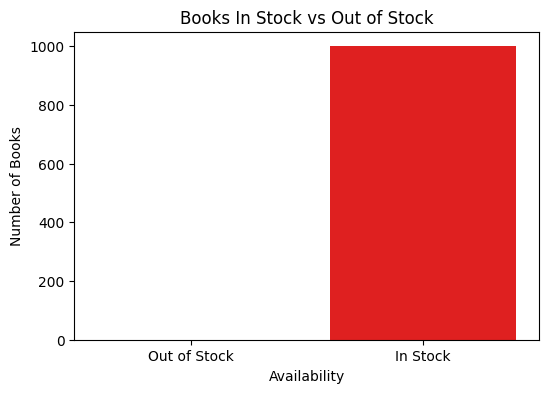

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x="In_Stock", data=df, color="r")
plt.title("Books In Stock vs Out of Stock")
plt.xlabel("Availability")
plt.ylabel("Number of Books")
plt.show()

**Most Expensive Books**

In [20]:
df.sort_values(by="Price", ascending=False).head(10)

,Title,Price,Availability,Rating,In_Stock
648,The Perfect Play (Play by Play #1),59.99,In stock,3,NaN
617,Last One Home (New Beginnings #1),59.98,In stock,3,NaN
860,Civilization and Its Discontents,59.95,In stock,2,NaN
560,The Barefoot Contessa Cookbook,59.92,In stock,5,NaN
366,The Diary of a Young Girl,59.90,In stock,3,NaN
657,The Bone Hunters (Lexy Vaughan & Steven Macaul...,59.71,In stock,3,NaN
133,Thomas Jefferson and the Tripoli Pirates: The ...,59.64,In stock,1,NaN
387,Boar Island (Anna Pigeon #19),59.48,In stock,3,NaN
549,The Man Who Mistook His Wife for a Hat and Oth...,59.45,In stock,4,NaN
393,The Improbability of Love,59.45,In stock,1,NaN


**Correlation**

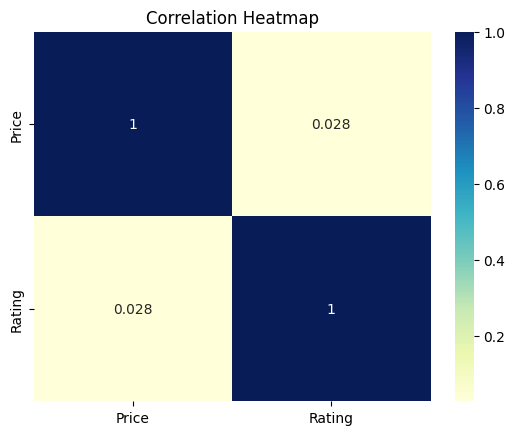

In [21]:
df[["Price", "Rating"]].corr()
sns.heatmap(df[["Price", "Rating"]].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

## 💾 Export Clean Dataset

We export this data to CSV for visualization in Power BI.

In [27]:
df.to_csv("books_clean.csv", index=False)

In [28]:
from google.colab import files
files.download('books_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📈 Power BI Dashboard Overview

**Dashboard Features:**
- Ratings breakdown (Pie Chart)
- Price distribution (Histogram)
- Summary cards (Total Books, Average Price, Average Rating)

**Dataset Source:**
BooksToScrape.com

**Date Collected:**
July 2025

**Notes:**
- Single page (1000 books)
- Ratings mapped from words to numbers


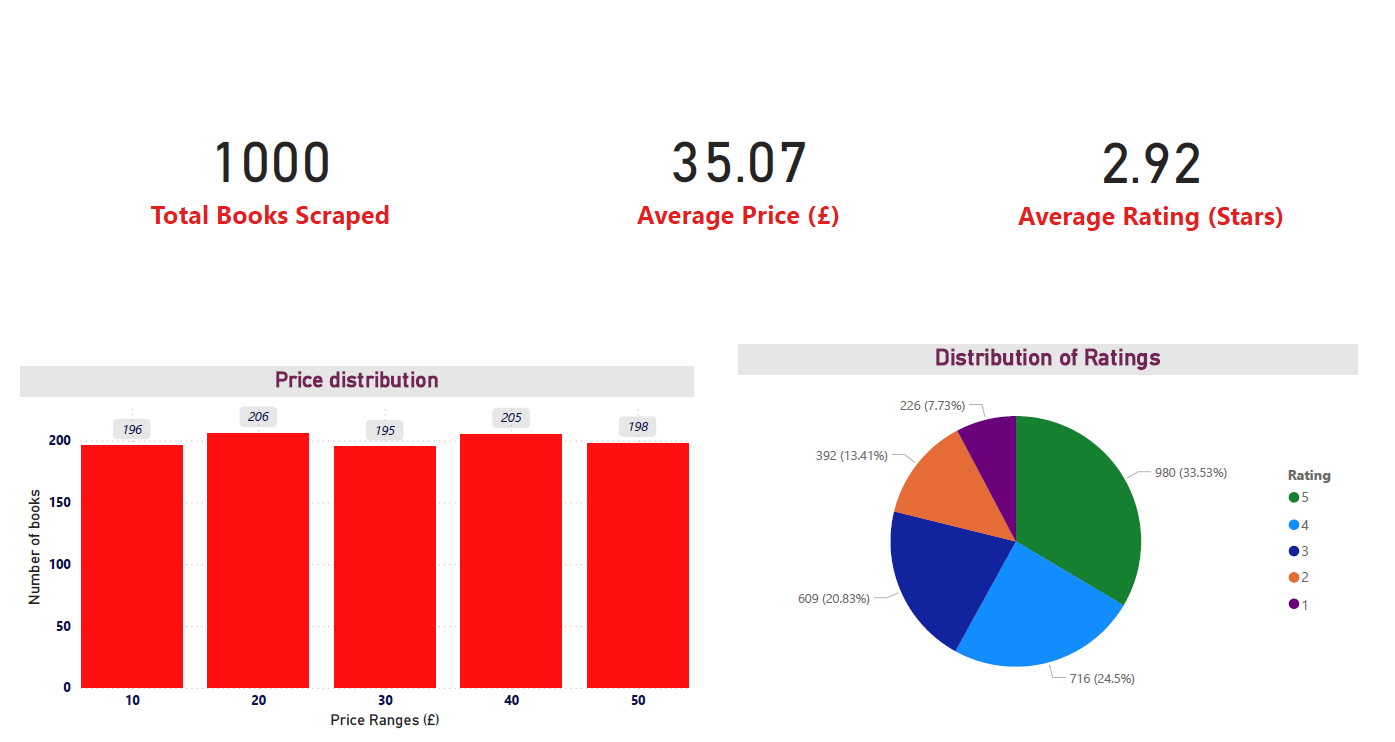

## ✅ Conclusion

This project demonstrates:
- End-to-end workflow from scraping to dashboarding
- Basic data cleaning and EDA
- Power BI dashboard creation for clear presentation

**Next Steps:**
- Add category and description fields
- Automate regular data refresh

---